# Libraries and functions

In [15]:
#!/usr/bin/env python -W ignore::DeprecationWarning


import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import xgboost
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import preprocessing
import graphviz 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# Stacking
from vecstack import stacking
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import pyltr





from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

    
%matplotlib inline
import seaborn as sns
sns.set(context = 'paper', palette = 'winter_r', style = 'darkgrid', rc= {'figure.facecolor': 'gray',}, font_scale=1.5)


def grid(model,parameters):
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 3, 
                        scoring = 'roc_auc')
    grid.fit(npX,npy_binary.ravel()) #npy
    return grid.best_score_, grid.best_estimator_.get_params()

def imp_features(model, model_name, params):
    Model = model(**params)
    Model.fit(npX,npy)
    names = X.columns
    feature = Model.feature_importances_
   
    important_features = pd.Series(data = feature, index = names,)
    important_features = important_features.sort_values(ascending = True)
    return important_features.plot(kind = 'barh', grid = False,title = model_name)

def f_selection(model,model_name, params, n):
    
    Model = model(**params)
    Model.fit(npX,npy)
    names = X.columns
    feature = Model.feature_importances_
    #selector = RFECV(Model, step=1, cv=15)
    selector = RFE(Model, n, step=1)
    selector = selector.fit(npX,npy)
    
    important_features = pd.Series(data = feature, index = names,)
    important_features = important_features.sort_values(ascending = False)
    return important_features, names, selector.get_support(indices=True)

def testing_confusion_phase(y_test,test):
    
    lb = preprocessing.LabelBinarizer()
    ytest_binary=lb.fit_transform(y_test)


# predicted values
    lb = preprocessing.LabelBinarizer()
    test_binary=lb.fit_transform(test)


    print('The roc_auc score is:',roc_auc_score(ytest_binary, test_binary))


    cm = confusion_matrix(ytest_binary, test_binary)

    TP, TN, FP, FN = cm[1,1], cm[0, 0], cm[0,1], cm[1,0]
    print("Outcomes on test data: \n", 
      "Sensitivity/Recall = {:.3%}".format(TP/(TP+FN)), '\n',
      "Specificity = {:.3%}".format(TN/(TN+FP)), '\n',
     "Accuracy = {:.3%}".format((TP+TN)/(TP+TN+FP+FN))) # Validated against output of sklearn metrics' accuracy_score class


    sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=["Lost", "Won"], 
           yticklabels=["Lost", "Won"])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for test data')
    plt.show()
    

clf_rf = RandomForestClassifier() #RandomForest
clf_et = ExtraTreesClassifier() #ExtraTrees
clf_bc = BaggingClassifier() #Bagging
clf_ada = AdaBoostClassifier() #AdaBoost
clf_dt = DecisionTreeClassifier() #DecisionTree
clf_xg = XGBClassifier() #XGBoost
clf_lr = LogisticRegression() #LogisticRegression
clf_svm = SVC() #SVM
clf_nnet = MLPClassifier() # nnet

# Data Processing

In [16]:
import pandas as pd

greece = pd.read_csv('greece.csv')
df = pd.read_csv('outputdata.csv',encoding='latin1')
greece['dgreece']= 100*greece['Greece_price'].diff()/greece['Greece_price']
df = df.merge(greece,on = 'Quotation_Date', how = 'left')
df = df.dropna()
df['TranspCosts_per_Kg']=abs(df['TranspCosts_per_Kg'])
count_ratio = df.groupby('Customer').agg({'FlgQuotationStatus_Final': lambda x: len(x[x=='Won'])/len(x)}).rename(columns={'FlgQuotationStatus_Final':'Quotation_won_ratio'})
count_ratio.reset_index(level=0, inplace=True)
df = df.merge(count_ratio, how = 'outer', on = 'Customer')
df['Creation_Date'] = pd.to_datetime(df['Creation_Date'])
df = df.drop(['Customer_Country','Repackers','Quotation_Date'], axis = 1)
df = pd.get_dummies(df, columns = ['Cheese_Type','Segment','Volatility','AgeGroup','Ingredient_Applications'])
df_opt = (df.loc[(df.Customer == 'Frischpack GmbH')& (df.Cheese_Type_GOUDA == 1)][-1:]).copy()
df['PR_greece'] = df['SP_2']/df['Greece_price_x']
df.sort_values(['Customer', 'Creation_Date'], inplace=True)
df['date_diff'] = df.groupby(['Customer'])[['Creation_Date']].transform(lambda x: x.diff()).fillna(0)
df[['date_diff']]=df['date_diff'].dt.days
df[['dVolume','dValue','dSales_Price','dGreece_price','dPR_greece','dSP_2','dTransport']] = df.groupby(['Customer','Cheese_Type_GOUDA'], as_index= False)['Volume','Value','Sales_Price','Greece_price_x','PR_greece','SP_2','TranspCosts_per_Kg'].transform(lambda x: (x.diff()).fillna(0))

df=df.drop(['Greece_price_y'],axis=1)

In [3]:
# df['Production_Balance'] = 0
df['Sales']=0
df['month_year'] = df['Creation_Date'].dt.to_period('M')
# df.loc[df['month_year'] == pd.to_datetime('2016-01').to_period('M'), 'Production_Balance'] = 350
# df.loc[df['month_year'] == pd.to_datetime('2016-02').to_period('M'), 'Production_Balance'] = 850
# df.loc[df['month_year'] == pd.to_datetime('2016-03').to_period('M'), 'Production_Balance'] = 2000
# df.loc[df['month_year'] == pd.to_datetime('2016-04').to_period('M'), 'Production_Balance'] = 900
# df.loc[df['month_year'] == pd.to_datetime('2016-05').to_period('M'), 'Production_Balance'] = 900
# df.loc[df['month_year'] == pd.to_datetime('2016-06').to_period('M'), 'Production_Balance'] = 100
# df.loc[df['month_year'] == pd.to_datetime('2016-07').to_period('M'), 'Production_Balance'] = 250
# df.loc[df['month_year'] == pd.to_datetime('2016-08').to_period('M'), 'Production_Balance'] = -900
# df.loc[df['month_year'] == pd.to_datetime('2016-09').to_period('M'), 'Production_Balance'] = -1000
# df.loc[df['month_year'] == pd.to_datetime('2016-10').to_period('M'), 'Production_Balance'] = 200
# df.loc[df['month_year'] == pd.to_datetime('2016-11').to_period('M'), 'Production_Balance'] = 400
# df.loc[df['month_year'] == pd.to_datetime('2016-12').to_period('M'), 'Production_Balance'] = 1700
# df.loc[df['month_year'] == pd.to_datetime('2017-01').to_period('M'), 'Production_Balance'] = 800
# df.loc[df['month_year'] == pd.to_datetime('2017-02').to_period('M'), 'Production_Balance'] = 2200
# df.loc[df['month_year'] == pd.to_datetime('2017-03').to_period('M'), 'Production_Balance'] = 1400
# df.loc[df['month_year'] == pd.to_datetime('2017-04').to_period('M'), 'Production_Balance'] = -400
# df.loc[df['month_year'] == pd.to_datetime('2017-05').to_period('M'), 'Production_Balance'] = -500
# df.loc[df['month_year'] == pd.to_datetime('2017-06').to_period('M'), 'Production_Balance'] = -400
# df.loc[df['month_year'] == pd.to_datetime('2017-07').to_period('M'), 'Production_Balance'] = -350
# df.loc[df['month_year'] == pd.to_datetime('2017-08').to_period('M'), 'Production_Balance'] = 800
# df.loc[df['month_year'] == pd.to_datetime('2017-09').to_period('M'), 'Production_Balance'] = 1500
# df.loc[df['month_year'] == pd.to_datetime('2017-10').to_period('M'), 'Production_Balance'] = 250
# df.loc[df['month_year'] == pd.to_datetime('2017-11').to_period('M'), 'Production_Balance'] = 1000
# df.loc[df['month_year'] == pd.to_datetime('2017-12').to_period('M'), 'Production_Balance'] = 1600
# df.loc[df['month_year'] == pd.to_datetime('2018-01').to_period('M'), 'Production_Balance'] = -700
# df.loc[df['month_year'] == pd.to_datetime('2018-02').to_period('M'), 'Production_Balance'] = -100
# df.loc[df['month_year'] == pd.to_datetime('2018-03').to_period('M'), 'Production_Balance'] = -850
# df.loc[df['month_year'] == pd.to_datetime('2018-04').to_period('M'), 'Production_Balance'] = 300
# df.loc[df['month_year'] == pd.to_datetime('2018-05').to_period('M'), 'Production_Balance'] = -1000
# df.loc[df['month_year'] == pd.to_datetime('2018-06').to_period('M'), 'Production_Balance'] = -700
# df.loc[df['month_year'] == pd.to_datetime('2018-07').to_period('M'), 'Production_Balance'] = -500
# df.loc[df['month_year'] == pd.to_datetime('2018-08').to_period('M'), 'Production_Balance'] = -2800
# df.loc[df['month_year'] == pd.to_datetime('2018-09').to_period('M'), 'Production_Balance'] = -1000
# df.loc[df['month_year'] == pd.to_datetime('2018-10').to_period('M'), 'Production_Balance'] = 600
# df.loc[df['month_year'] == pd.to_datetime('2018-11').to_period('M'), 'Production_Balance'] = 2000
# df.loc[df['month_year'] == pd.to_datetime('2018-12').to_period('M'), 'Production_Balance'] = 2100


df.loc[df['month_year'] == pd.to_datetime('2016-01').to_period('M'), 'Sales'] = 18150.233887
df.loc[df['month_year'] == pd.to_datetime('2016-02').to_period('M'), 'Sales'] = 19924.3405
df.loc[df['month_year'] == pd.to_datetime('2016-03').to_period('M'), 'Sales'] = 22020.457165
df.loc[df['month_year'] == pd.to_datetime('2016-04').to_period('M'), 'Sales'] = 21589.246198
df.loc[df['month_year'] == pd.to_datetime('2016-05').to_period('M'), 'Sales'] = 21706.505662
df.loc[df['month_year'] == pd.to_datetime('2016-06').to_period('M'), 'Sales'] = 21149.638548
df.loc[df['month_year'] == pd.to_datetime('2016-07').to_period('M'), 'Sales'] = 18265.543153
df.loc[df['month_year'] == pd.to_datetime('2016-08').to_period('M'), 'Sales'] = 19766.190484
df.loc[df['month_year'] == pd.to_datetime('2016-09').to_period('M'), 'Sales'] = 20048.347281
df.loc[df['month_year'] == pd.to_datetime('2016-10').to_period('M'), 'Sales'] = 18063.732871
df.loc[df['month_year'] == pd.to_datetime('2016-11').to_period('M'), 'Sales'] = 18144.777343
df.loc[df['month_year'] == pd.to_datetime('2016-12').to_period('M'), 'Sales'] = 16037.076585
df.loc[df['month_year'] == pd.to_datetime('2017-01').to_period('M'), 'Sales'] = 18244
df.loc[df['month_year'] == pd.to_datetime('2017-02').to_period('M'), 'Sales'] = 16738
df.loc[df['month_year'] == pd.to_datetime('2017-03').to_period('M'), 'Sales'] = 20334
df.loc[df['month_year'] == pd.to_datetime('2017-04').to_period('M'), 'Sales'] = 19096
df.loc[df['month_year'] == pd.to_datetime('2017-05').to_period('M'), 'Sales'] = 20945
df.loc[df['month_year'] == pd.to_datetime('2017-06').to_period('M'), 'Sales'] = 19724
df.loc[df['month_year'] == pd.to_datetime('2017-07').to_period('M'), 'Sales'] = 16010
df.loc[df['month_year'] == pd.to_datetime('2017-08').to_period('M'), 'Sales'] = 17632
df.loc[df['month_year'] == pd.to_datetime('2017-09').to_period('M'), 'Sales'] = 16388
df.loc[df['month_year'] == pd.to_datetime('2017-10').to_period('M'), 'Sales'] = 16415
df.loc[df['month_year'] == pd.to_datetime('2017-11').to_period('M'), 'Sales'] = 18058
df.loc[df['month_year'] == pd.to_datetime('2017-12').to_period('M'), 'Sales'] = 16053
df.loc[df['month_year'] == pd.to_datetime('2018-01').to_period('M'), 'Sales'] = 19007.721823
df.loc[df['month_year'] == pd.to_datetime('2018-02').to_period('M'), 'Sales'] = 19181.119919
df.loc[df['month_year'] == pd.to_datetime('2018-03').to_period('M'), 'Sales'] = 19787.444863
df.loc[df['month_year'] == pd.to_datetime('2018-04').to_period('M'), 'Sales'] = 16884.283094
df.loc[df['month_year'] == pd.to_datetime('2018-05').to_period('M'), 'Sales'] = 19501.825713
df.loc[df['month_year'] == pd.to_datetime('2018-06').to_period('M'), 'Sales'] = 18237.525663
df.loc[df['month_year'] == pd.to_datetime('2018-07').to_period('M'), 'Sales'] = 16935.858738
df.loc[df['month_year'] == pd.to_datetime('2018-08').to_period('M'), 'Sales'] = 20871.050881
df.loc[df['month_year'] == pd.to_datetime('2018-09').to_period('M'), 'Sales'] = 18716.998901
df.loc[df['month_year'] == pd.to_datetime('2018-10').to_period('M'), 'Sales'] = 18376.869341
df.loc[df['month_year'] == pd.to_datetime('2018-11').to_period('M'), 'Sales'] = 19000
df.loc[df['month_year'] == pd.to_datetime('2018-12').to_period('M'), 'Sales'] = 19300

df = df.drop(['month_year'],axis=1)



# Remove Outliers

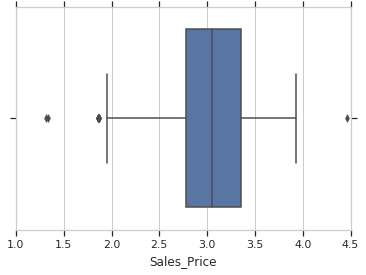

In [4]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=df["Sales_Price"])
# B=plt.boxplot(df["Sales_Price"])
# [item.get_ydata() for item in B['whiskers']]
df_outlier=df.loc[(df['Sales_Price']>=1.94)&(df['Sales_Price']<=3.93)]
df=df_outlier

In [5]:
list(df)

['Customer',
 'TranspCosts_per_Kg',
 'Creation_Date',
 'Volume',
 'Value',
 'Sales_Price',
 'FlgQuotationStatus_Final',
 'SP_2',
 'CustomerAge',
 'STDEVAVG',
 'Greece_price_x',
 'dgreece_x',
 'PR_greece',
 'dgreece_y',
 'Quotation_won_ratio',
 'Cheese_Type_EDAM',
 'Cheese_Type_GOUDA',
 'Segment_0',
 'Segment_Industrial Food Applications',
 'Segment_Ingredient Applications',
 'Segment_Repackers',
 'Segment_Resellers/C&C/Wholesale',
 'Volatility_High',
 'Volatility_Low',
 'AgeGroup_0-2',
 'AgeGroup_>2',
 'Ingredient_Applications_0',
 'Ingredient_Applications_1',
 'date_diff',
 'dVolume',
 'dValue',
 'dSales_Price',
 'dGreece_price',
 'dPR_greece',
 'dSP_2',
 'dTransport',
 'Production_Balance',
 'Sales']

In [6]:
#list(df)
#df=df.drop(['AgeGroup_>2','AgeGroup_0-2','Cheese_Type_GOUDA','Cheese_Type_EDAM','Ingredient_Applications_0','Ingredient_Applications_1'], axis = 1)

# positive 1 correlation
df=df.drop(['SP_2','dgreece_y', 'dSP_2','Segment_Ingredient Applications'], axis = 1)
# negative (-1) correlation
df=df.drop(['Cheese_Type_EDAM','Volatility_High','AgeGroup_>2','Ingredient_Applications_0'], axis = 1)

# df=df.drop(['date_diff',
#  'dVolume',
#  'dValue',
#  'dSales_Price',
#  'dGreece_price',
#  'dPR_greece',
#  'dTransport','dgreece_x'], axis = 1)

# xgboost for Frischpack

In [42]:

test_original = df.loc[df['Customer'] == 'Frischpack GmbH'][-20:] #excludes frishcpack
train_original = df[~df.index.isin(test_original.index)]


y = df['FlgQuotationStatus_Final']
X = df.drop(['FlgQuotationStatus_Final','Customer','Creation_Date'], axis = 1)
y_train = train_original['FlgQuotationStatus_Final']
X_train = train_original.drop(['FlgQuotationStatus_Final','Customer','Creation_Date'], axis = 1)
y_test = test_original['FlgQuotationStatus_Final']
X_test = test_original.drop(['FlgQuotationStatus_Final','Customer','Creation_Date'], axis = 1)


xgb = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.08, gamma=0.8, subsample=0.5, colsample_bytree=0.5, max_depth=10,max_delta_step = 1)

# loo = LeaveOneOut()
scores = cross_val_score(xgb, X_train , y_train , cv=5)
#print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))
xgb.fit(X_train,y_train)
test = xgb.predict(X_test)
test_prob = xgb.predict_proba(X_test)
#print (test)
#print (y_test==test)
print(sum(y_test==test)/len(test))

Mean accuracy: 0.87
1.0


# Split into train and test set

In [17]:
train, test = train_test_split(df, test_size=0.25)


y = df['FlgQuotationStatus_Final']
X = df.drop(['FlgQuotationStatus_Final','Customer','Creation_Date'], axis = 1)
y_train = train['FlgQuotationStatus_Final']
X_train = train.drop(['FlgQuotationStatus_Final','Customer','Creation_Date'], axis = 1)
y_test = test['FlgQuotationStatus_Final']
X_test = test.drop(['FlgQuotationStatus_Final','Customer','Creation_Date'], axis = 1)
trainNames=list(X_train)

In [41]:
# you have to run first xgboost or a method with the f_selection function
#X_train=X_train[list(Top_n_Features)] 
#X_test=X_test[list(Top_n_Features)] 


25

# Balance the data using SMOTE

In [18]:
sum(train['FlgQuotationStatus_Final']=='Won')/sum(train['FlgQuotationStatus_Final']=='Lost')

#smote = SMOTETomek(ratio='auto') #try also this
smote = SMOTE(ratio='minority')
X_train,y_train= smote.fit_sample(X_train, y_train)

# Scaling the features

In [19]:
SP=X_test['Sales_Price']

scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  

X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  


npX = np.array(X_train).copy()
npy = np.array(y_train).copy()

lb = preprocessing.LabelBinarizer()
npy_binary=lb.fit_transform(npy)



# Check the power of each model

In [10]:

Classifiers = ['RandomForest','ExtraTrees','Bagging','AdaBoost','DecisionTree','XGBoost','LogisticRegression','SVM','NNET']
scores = []
models = [clf_rf, clf_et, clf_bc, clf_ada, clf_dt, clf_xg, clf_lr, clf_svm, clf_nnet]
for model in models:
    score = cross_val_score(model, npX, npy_binary, scoring = 'roc_auc', cv = 10, n_jobs = -1).mean()
    scores.append(score)
    
mode = pd.DataFrame(scores, index = Classifiers, columns = ['score']).sort_values(by = 'score',
             ascending = False)
mode

/home/makarama/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/makarama/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/makarama/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/makarama/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: Dat

,score
XGBoost,0.987924
RandomForest,0.985086
ExtraTrees,0.984532
NNET,0.984085
Bagging,0.980725
AdaBoost,0.979124
SVM,0.975420
LogisticRegression,0.953395
DecisionTree,0.917828


# Correlation heatmap of the features

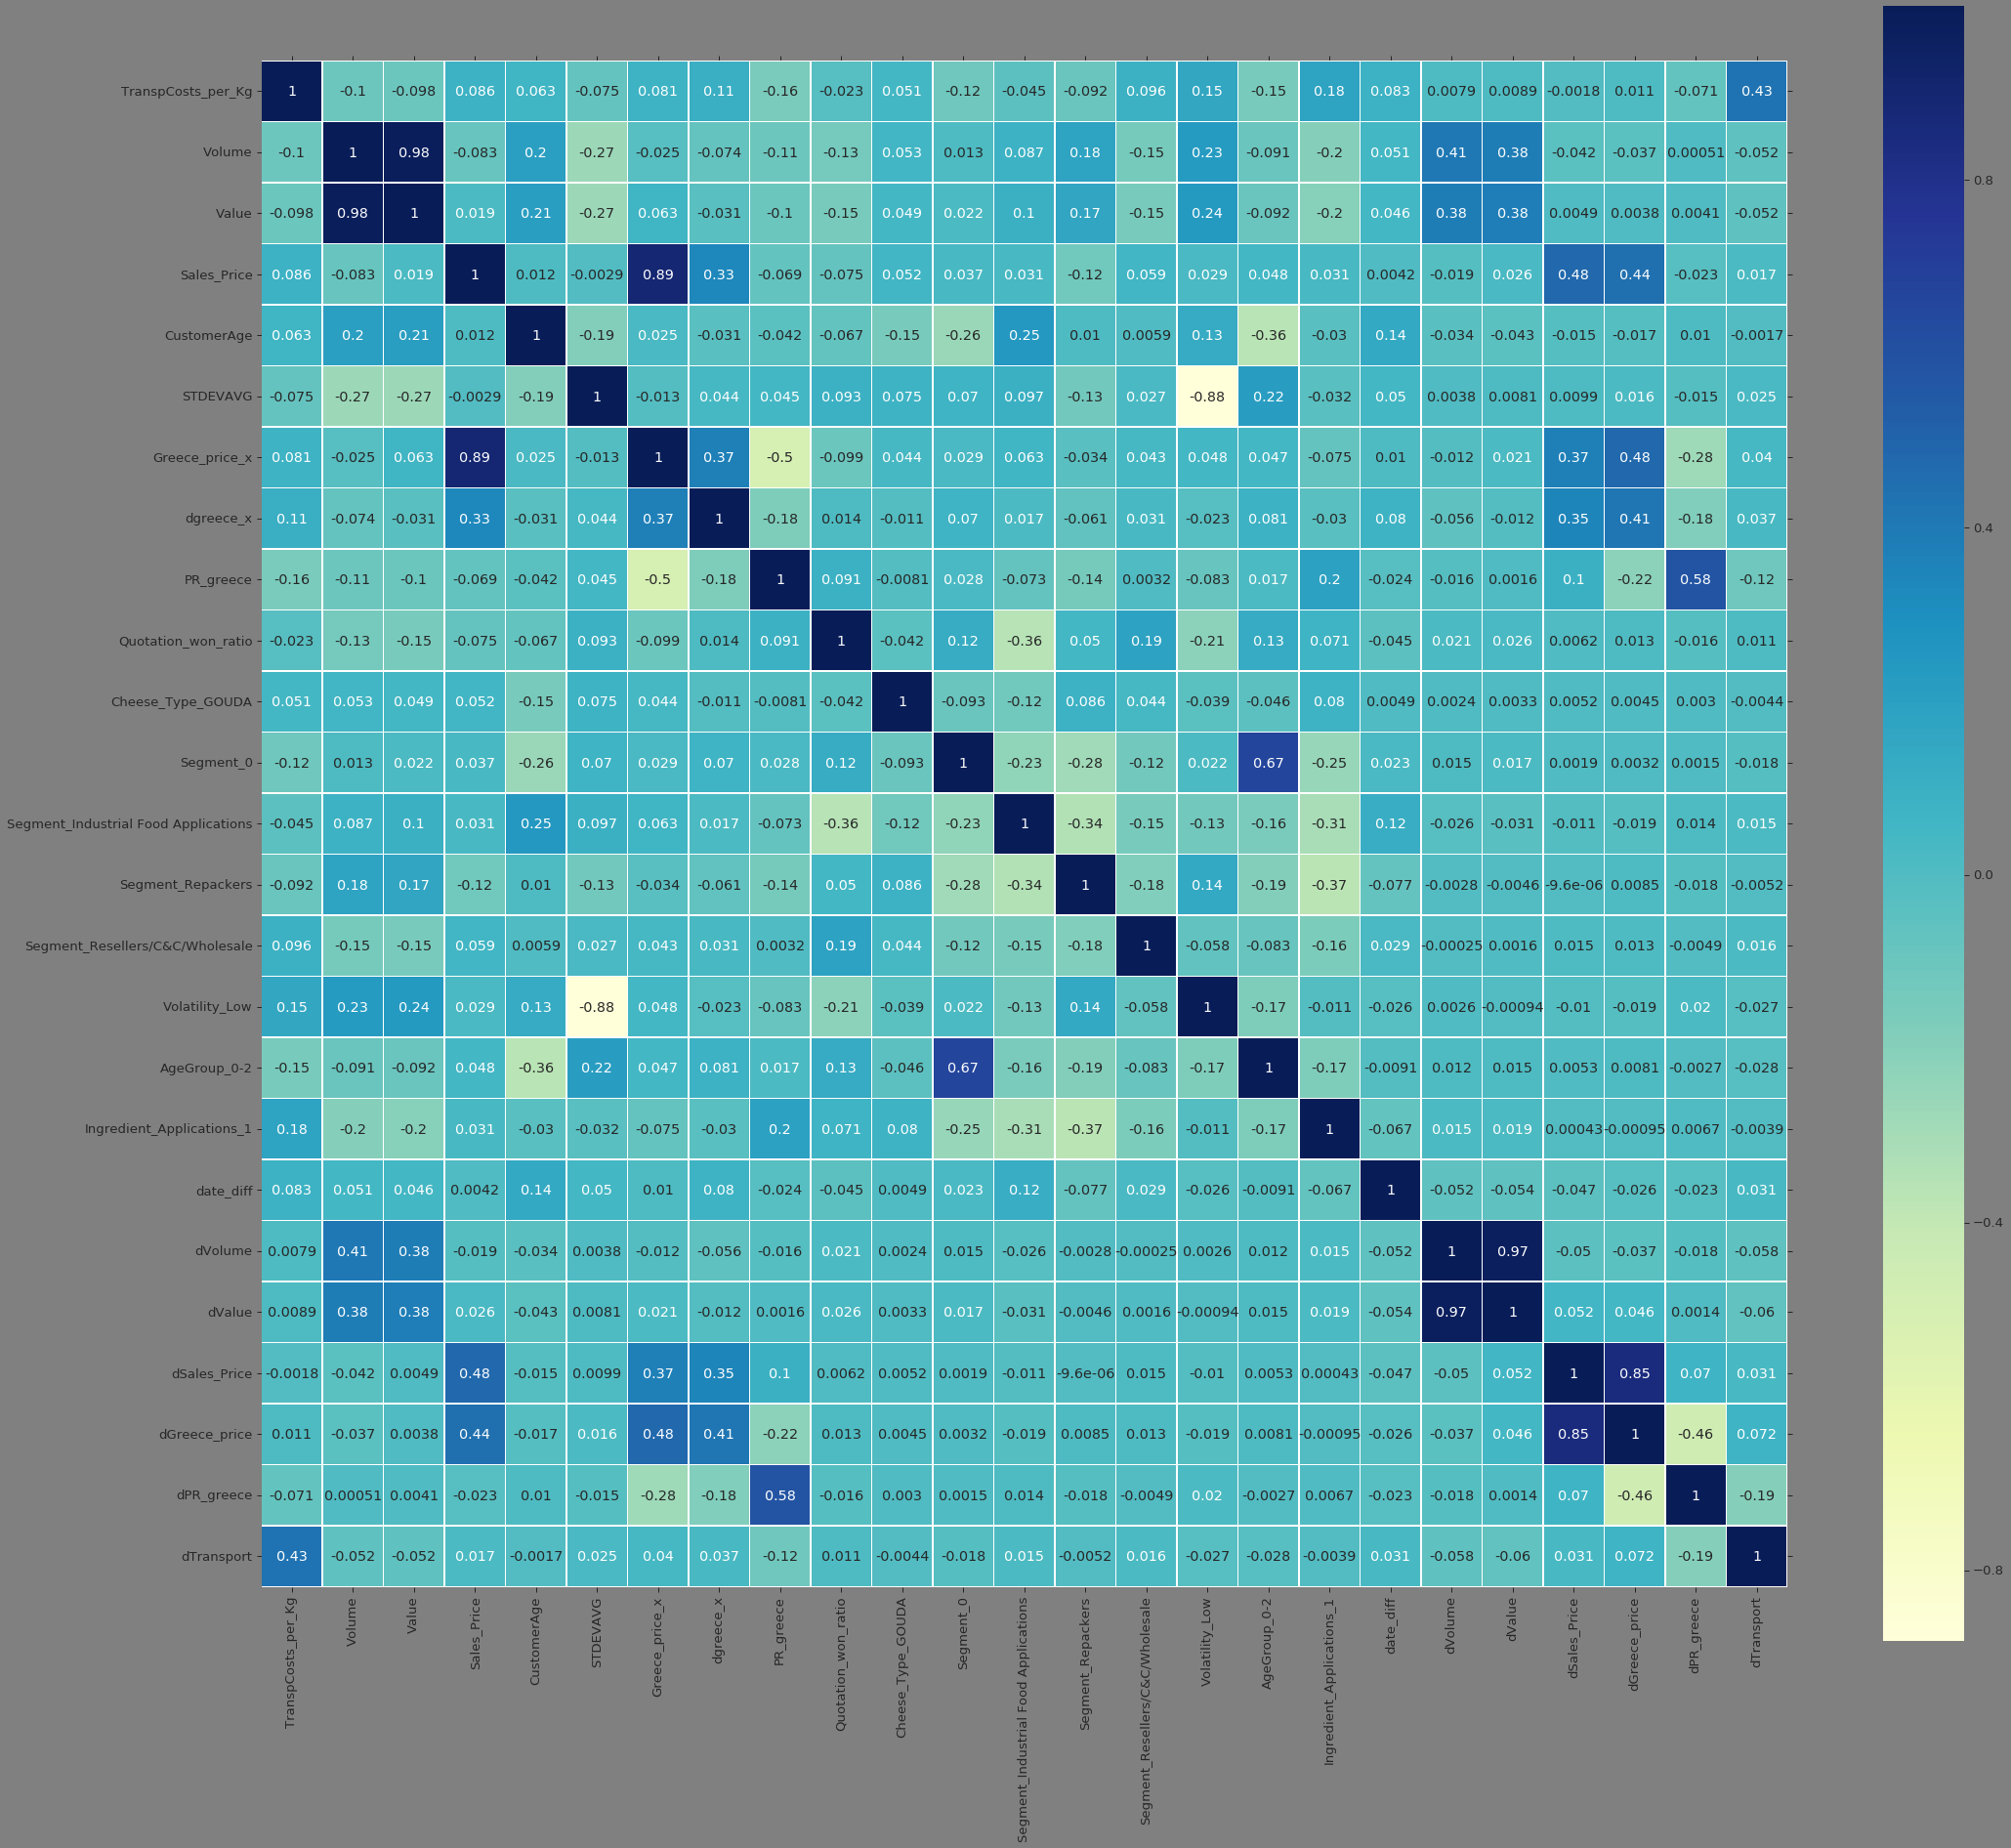

In [144]:
f, ax = plt.subplots(figsize = [35,30])
sns.heatmap(df.corr(),linewidths = .5, annot = True, cmap = 'YlGnBu', square = True)


# ################ Models ################### ################ 

# xgboost for all companies

In [20]:

#clf_xg.get_params() # get a list of the xgboost parameters.
parameters_xg = {
        'learning_rate': [0.05,0.1],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4],
        'n_estimators': [400],  
        'min_child_weight': [4], 
        'reg_alpha': [6,0], 
        'reg_lambda': [1,3,8],
        'max_delta_step':[2],
        'nthread':[-1], # to run at all cpu threads
        }

best_score_xg, best_params_xg = grid(clf_xg,parameters_xg)

#imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)

xgb = xgboost.XGBClassifier(**best_params_xg)



xgb.fit(X_train,y_train)
test = xgb.predict(X_test)
test_prob = xgb.predict_proba(X_test)
#print (test)
#print (y_test==test)
#print(sum(y_test==test)/len(test)) # that gives accuracy but we don't want that.

# See top n features

In [12]:
# select top n features
n=25;
important_features, names, selected_features=f_selection(XGBClassifier, 'XGBoostClassifier', best_params_xg, n)

# top n features according to RFE algorithm:
Top_n_Features=names[selected_features]
Top_n_Features


Index(['TranspCosts_per_Kg', 'Volume', 'Value', 'Sales_Price', 'CustomerAge',
       'STDEVAVG', 'Greece_price_x', 'dgreece_x', 'PR_greece',
       'Quotation_won_ratio', 'Cheese_Type_GOUDA',
       'Segment_Industrial Food Applications', 'Segment_Repackers',
       'Volatility_Low', 'AgeGroup_0-2', 'Ingredient_Applications_1',
       'date_diff', 'dVolume', 'dValue', 'dSales_Price', 'dGreece_price',
       'dPR_greece', 'dTransport', 'Production_Balance', 'Sales'],
      dtype='object')

In [13]:
important_features

PR_greece                               0.092172
Quotation_won_ratio                     0.077020
Sales_Price                             0.074495
TranspCosts_per_Kg                      0.068813
dPR_greece                              0.061869
dSales_Price                            0.059975
Value                                   0.057449
dValue                                  0.056187
STDEVAVG                                0.051768
Production_Balance                      0.043561
dgreece_x                               0.041667
dVolume                                 0.032828
Volume                                  0.031566
Sales                                   0.031566
dGreece_price                           0.028409
Greece_price_x                          0.027778
Cheese_Type_GOUDA                       0.026515
date_diff                               0.025884
Ingredient_Applications_1               0.022727
Segment_Repackers                       0.022727
dTransport          

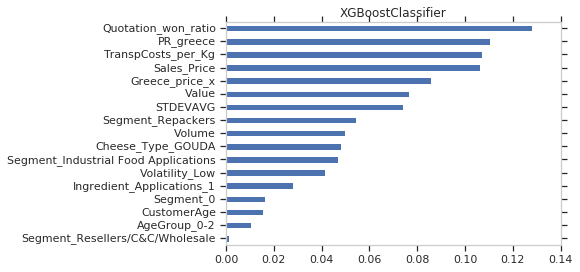

In [85]:
imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)

# xgboost, testing Phase: using the roc_auc metric

The roc_auc score is: 0.92069567553
Outcomes on test data: 
 Sensitivity/Recall = 95.098% 
 Specificity = 89.041% 
 Accuracy = 93.502%


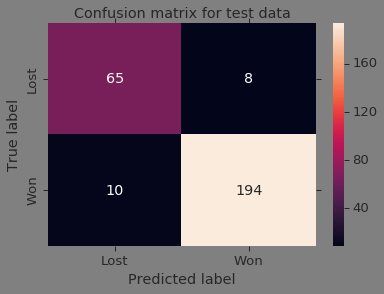

In [22]:
testing_confusion_phase(y_test,test)

# Random Forest for all companies

In [49]:


# parameters_rf = {
#     'bootstrap': [True, False],
#     'max_depth': [80, 90, 100],
#     'max_features': [7,'auto',None],
#     'min_samples_leaf': [3, 4],
#     'min_samples_split': [8, 10],
#     'n_estimators': [100, 200],
#     'n_jobs': [-1],
#     'warm_start': [True,False],
#     'criterion': ['gini'],
#     'oob_score': [True,False],
#     #'random_state':[1,7,],
# }

parameters_rf = {
    'bootstrap': [True],
    'max_depth': [ 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [ 200, 300],
    
}


best_score_rf, best_params_rf = grid(clf_rf,parameters_rf)

#imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)

rf = RandomForestClassifier(**best_params_rf)



rf.fit(X_train,y_train)
test = rf.predict(X_test)
test_prob = rf.predict_proba(X_test)
#print (test)
#print (y_test==test)
#print(sum(y_test==test)/len(test)) # that gives accuracy but we don't want that.

# Random Forest, testing Phase: using the roc_auc metric

The roc_auc score is: 0.882459505541
Outcomes on test data: 
 Sensitivity/Recall = 98.551% 
 Specificity = 77.941% 
 Accuracy = 93.455%


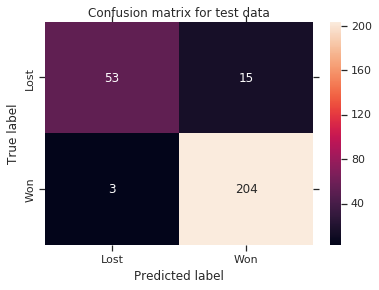

In [50]:
testing_confusion_phase(y_test,test)

# Bagging for all companies

In [23]:
parameters_bc = {
    'n_estimators': np.arange(10, 101, 10), 
}


best_score_bc, best_params_bc = grid(clf_bc,parameters_bc)

#imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)

bc = BaggingClassifier(**best_params_bc)



bc.fit(X_train,y_train)
test = bc.predict(X_test)
test_prob = bc.predict_proba(X_test)

In [7]:
imp_features(BaggingClassifier, 'BaggingClassifier', best_params_bc)


AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

# Bagging, testing Phase: using the roc_auc metric

The roc_auc score is: 0.896253021757
Outcomes on test data: 
 Sensitivity/Recall = 97.059% 
 Specificity = 82.192% 
 Accuracy = 93.141%


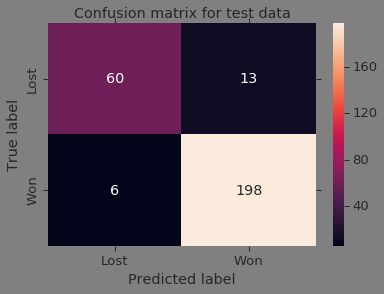

In [10]:
testing_confusion_phase(y_test,test)

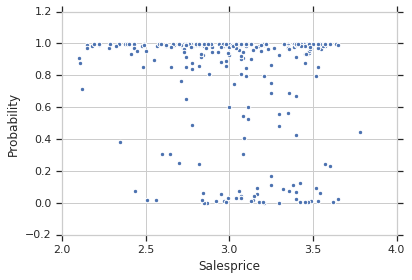

In [35]:
plt.scatter(SP.values,test_prob[:,1])
plt.xlabel('Salesprice')
plt.ylabel('Probability')

# Adaboost for all companies

In [53]:


parameters_ada = {
              'n_estimators': [25, 50, 100, 150, 250] ,
              'learning_rate':[0.01,0.025,0.05,0.1],
             }

best_score_ada, best_params_ada = grid(clf_ada,parameters_ada)

#imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)

ada = AdaBoostClassifier(**best_params_ada)



ada.fit(X_train,y_train)
test = ada.predict(X_test)
test_prob = ada.predict_proba(X_test)
#print (test)
#print (y_test==test)
#print(sum(y_test==test)/len(test)) # that gives accuracy but we don't want that.

# Adaboost, testing Phase: using the roc_auc metric


The roc_auc score is: 0.887716680875
Outcomes on test data: 
 Sensitivity/Recall = 93.720% 
 Specificity = 83.824% 
 Accuracy = 91.273%


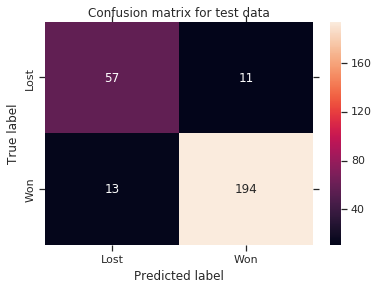

In [54]:
testing_confusion_phase(y_test,test)

# ExtraTreesClassifier for all companies

In [26]:
parameters_et=  {
     'n_estimators': [500,700,750],
     #'max_features': [25,50,75], 
     'criterion': ['entropy','gini'],
     'min_samples_split':[5,10,15],
     'max_depth':[50,75,100],
     'min_samples_leaf':[5,10,15],
 }

best_score_et, best_params_et = grid(clf_et,parameters_et)

#imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)

et = ExtraTreesClassifier(**best_params_et)



et.fit(X_train,y_train)
test = et.predict(X_test)
test_prob = et.predict_proba(X_test)


Traceback (most recent call last):
  File "/home/makarama/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py", line 187, in __call__
    y_pred = clf.decision_function(X)
AttributeError: 'ExtraTreesClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/makarama/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-227d98c9ae54>", line 10, in <module>
    best_score_et, best_params_et = grid(clf_et,parameters_et)
  File "<ipython-input-12-0137d8381a60>", line 61, in grid
    grid.fit(npX,npy_binary.ravel()) #npy
  File "/home/makarama/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py", line 639, in fit
    cv.split(X, y, groups)))
  File "/home/makarama/anaconda3/lib/python3.5/site-packages/sklearn/externals/jobli

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: Can't convert 'list' object to str implicitly

# ExtraTreesClassifier, testing Phase: using the roc_auc metric


The roc_auc score is: 0.864093723614
Outcomes on test data: 
 Sensitivity/Recall = 88.995% 
 Specificity = 83.824% 
 Accuracy = 87.726%


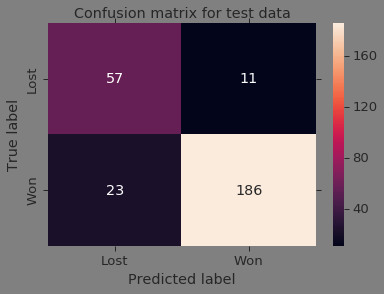

In [25]:
testing_confusion_phase(y_test,test)

# Neural net for all companies

In [74]:

parameters_nnet=  {
 'activation': ['relu', 'logistic', 'tanh'],
 'alpha': [0.0001,0.005],
 'hidden_layer_sizes': [(50,),(25,2)],
 'learning_rate_init': [0.001,0.025,0.05],
 'max_iter': [700,750],
 'random_state': [None,1],
 'solver': ['adam','lbfgs'], #'sgd'

 }

best_score_nnet, best_params_nnet = grid(clf_nnet,parameters_nnet)

#imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)
#clf_nnet.get_params()

nnet = MLPClassifier(**best_params_nnet)



nnet.fit(X_train,y_train)
test = nnet.predict(X_test)
test_prob = nnet.predict_proba(X_test)

# Neural net, testing Phase: using the roc_auc metric


The roc_auc score is: 0.864090909091
Outcomes on test data: 
 Sensitivity/Recall = 91.000% 
 Specificity = 81.818% 
 Accuracy = 88.448%


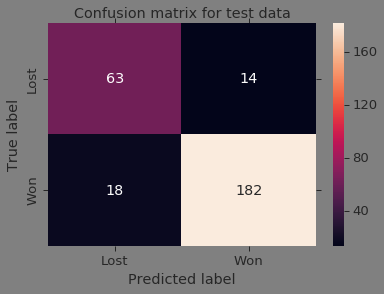

In [75]:
testing_confusion_phase(y_test,test)

# Support Vector Machines for all companies


In [ ]:
parameters_svm = {'kernel':('linear', 'rbf'), 
              'C':(1,0.25,0.5,0.75),
              'gamma': (1,2,3,'auto'),
              'decision_function_shape':('ovo','ovr'),
              'shrinking':(True,False),
              'probability':(True,True)}


best_score_svm, best_params_svm = grid(clf_svm,parameters_svm)

#imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)
#clf_nnet.get_params()

svm = SVC(**best_params_svm)



svm.fit(X_train,y_train)
test = svm.predict(X_test)
test_prob = svm.predict_proba(X_test)

KeyboardInterrupt: 

# Support Vector Machines, testing Phase: using the roc_auc metric


The roc_auc score is: 0.815133916963
Outcomes on test data: 
 Sensitivity/Recall = 91.084% 
 Specificity = 71.942% 
 Accuracy = 86.282%


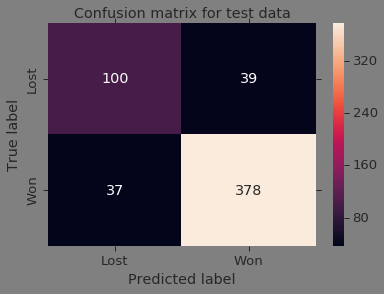

In [206]:
testing_confusion_phase(y_test,test)

# Logistic Regression for all companies


In [89]:
parameters_lr = {'C': np.arange(1e-05, 10, 0.2), 
                 'penalty': ('l2','l1'),
                 'warm_start':(True,False)
                }

best_score_lr, best_params_lr = grid(clf_lr,parameters_lr)

#imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)
#clf_nnet.get_params()

lr = LogisticRegression(**best_params_lr)



lr.fit(X_train,y_train)
test = lr.predict(X_test)
test_prob = lr.predict_proba(X_test)

In [30]:
np.arange(1e-4,1e-3,5e-5)

array([ 0.0001 ,  0.00015,  0.0002 ,  0.00025,  0.0003 ,  0.00035,
        0.0004 ,  0.00045,  0.0005 ,  0.00055,  0.0006 ,  0.00065,
        0.0007 ,  0.00075,  0.0008 ,  0.00085,  0.0009 ,  0.00095])

In [90]:
best_params_lr

{'C': 1.0000000000000001e-05,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': True}

# Logistic Regression, testing Phase: using the roc_auc metric


The roc_auc score is: 0.769472361809
Outcomes on test data: 
 Sensitivity/Recall = 78.894% 
 Specificity = 75.000% 
 Accuracy = 77.818%


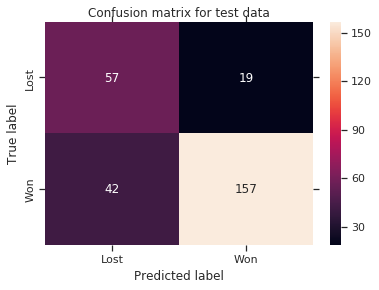

In [91]:
testing_confusion_phase(y_test,test)


# DecisionTreeClassifier 

In [ ]:
from sklearn import tree
parameters_dt = {'class_weight':[None,None], 
                  'criterion':['gini','gini'], 
                  'max_depth':[None,None],
                  'max_features':[None, None], 
                  'max_leaf_nodes':[None,None],
                  'min_impurity_split':[1e-07, 1e-07],
                  'min_samples_leaf':[1,1],
                  'min_samples_split':[2,2] ,
                  'min_weight_fraction_leaf':[0.0,0.0],
                  'presort':[False,False],
                  'random_state':[None, None],
                  'splitter':['best','best']}


best_score_dt, best_params_dt = grid(clf_dt,parameters_dt)







dt=tree.DecisionTreeClassifier(**best_params_dt)


dt.fit(X_train,y_train)
test = dt.predict(X_test)
test_prob = dt.predict_proba(X_test)

In [ ]:
# Plot tree

# dot_data = tree.export_graphviz(dt, out_file='tree.dot', 
#                          feature_names=trainNames)
#                          #filled=True, rounded=True,  
#                          #special_characters=True) 
# graph = graphviz.Source(dot_data)

# from graphviz import render
# render('dot', 'png', 'tree.dot')

# Ensemble model:

In [57]:
models_1 = [ 
    AdaBoostClassifier(**best_params_ada),
    
    #MLPClassifier(**best_params_nnet),
    
    #LogisticRegression(**best_params_lr),    
                         
    RandomForestClassifier(**best_params_rf),
        
    XGBClassifier(**best_params_xg),

    #SVC(**best_params_svm),
                  
    #ExtraTreesClassifier(**best_params_et),
    
    BaggingClassifier(**best_params_bc),
    
    
]



In [58]:
from sklearn.metrics import log_loss
S_train_1, S_test_1 = stacking(models_1,                   # list of models
                               X_train, y_train, X_test,   # data
                               
                               regression=False,           # classification task (if you need 
                                                           #     regression - set to True)
                               mode='oof_pred',            # mode: oof for train set, fit on full 
                                                           #     train and predict test set once
                               needs_proba=True,           # predict probabilities (if you need 
                                                           #     class labels - set to False) 
                               #save_dir='.',               # save result and log in current dir 
                                                           #     (to disable saving - set to None)
                               metric=roc_auc_score,            # metric: callable log_loss
                               n_folds=10,                  # number of folds
                               stratified=True,            # stratified split for folds
                               shuffle=True,               # shuffle the data
                               random_state=0,             # ensure reproducibility
                               verbose=False)                  # print all info


# Run this before the Ensembles below
# apply gridsearch on new data

lb = preprocessing.LabelBinarizer()
y_train_binary=lb.fit_transform(y_train)

def grid(model,parameters):
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, 
                        scoring = 'roc_auc')
    grid.fit(S_train_1,y_train_binary.ravel()) #npy
    return grid.best_score_, grid.best_estimator_.get_params()

# xgboost ensemble

In [210]:

best_score_xg, best_params_xg = grid(clf_xg,parameters_xg)
xgb = xgboost.XGBClassifier(**best_params_xg)
#xgb=RandomForestClassifier(**best_params_rf)


xgb.fit(S_train_1,y_train)
test = xgb.predict(S_test_1)
test_prob = xgb.predict_proba(S_test_1)

The roc_auc score is: 0.872826558031
Outcomes on test data: 
 Sensitivity/Recall = 96.867% 
 Specificity = 77.698% 
 Accuracy = 92.058%


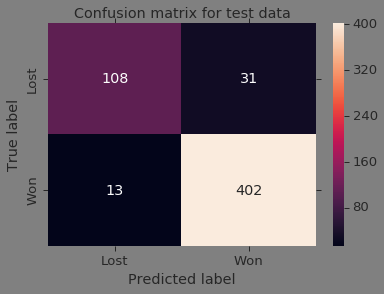

In [211]:
testing_confusion_phase(y_test,test)


# sensitivity=recall= tp/tp+fn
# specificity= tn/tn+fp

# accuracy= tp+tn/n

#n: total number of observ.

#[
 #   tn , fp,
  #  fn, tp
    
#]

# AdaBoostClassifier ensemble (RF,ADA,XGB,logistic,SVC)

In [43]:
best_score_ada, best_params_ada = grid(clf_ada,parameters_ada)
ada = AdaBoostClassifier(**best_params_ada)



ada.fit(S_train_1,y_train)
test = ada.predict(S_test_1)
test_prob = ada.predict_proba(S_test_1)


The roc_auc score is: 0.884446463729
Outcomes on test data: 
 Sensitivity/Recall = 96.244% 
 Specificity = 80.645% 
 Accuracy = 92.727%


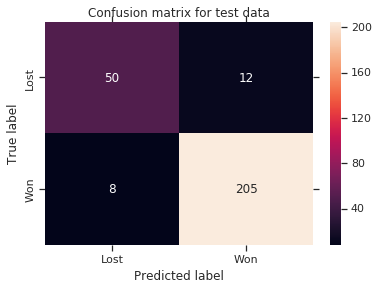

In [44]:
testing_confusion_phase(y_test,test)

# Logistic ensemble

In [63]:
best_score_lr, best_params_lr = grid(clf_lr,parameters_lr)
lr = LogisticRegression(**best_params_lr)



lr.fit(S_train_1,y_train)
test = lr.predict(S_test_1)
test_prob = lr.predict_proba(S_test_1)

The roc_auc score is: 0.884981528843
Outcomes on test data: 
 Sensitivity/Recall = 97.585% 
 Specificity = 79.412% 
 Accuracy = 93.091%


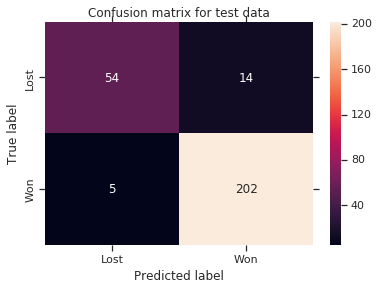

In [64]:
testing_confusion_phase(y_test,test)

# Bagging ensemble

In [61]:
best_score_bc, best_params_bc = grid(clf_bc,parameters_bc)
bc = BaggingClassifier(**best_params_bc)



bc.fit(S_train_1,y_train)
test = bc.predict(S_test_1)
test_prob = bc.predict_proba(S_test_1)

The roc_auc score is: 0.899687411196
Outcomes on test data: 
 Sensitivity/Recall = 97.585% 
 Specificity = 82.353% 
 Accuracy = 93.818%


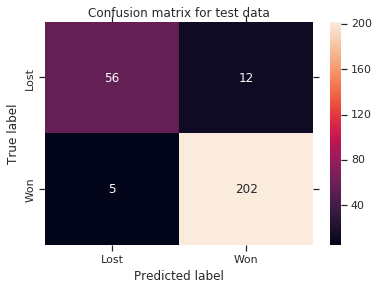

In [62]:
testing_confusion_phase(y_test,test)

# Change the classification threshold

In [ ]:

threshold=0.5
test_prob = bc.predict_proba(S_test_1)
test_prob2=test_prob[:,1]
test_prob2[test_prob2>=threshold]=1
test_prob2[test_prob2<threshold]=0
test_prob2l=list(test_prob2)
new_test = ['Won' if int(el)==1 else 'Lost' for el in test_prob2l]
testing_confusion_phase(y_test,new_test)

The roc_auc score is: 0.885165833712
Outcomes on test data: 
 Sensitivity/Recall = 91.549% 
 Specificity = 85.484% 
 Accuracy = 90.182%


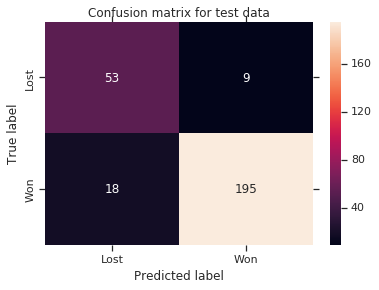

In [50]:
testing_confusion_phase(y_test,test)

,Customer,TranspCosts_per_Kg,Creation_Date,Volume,Value,Sales_Price,FlgQuotationStatus_Final,CustomerAge,STDEVAVG,Greece_price_x,...,Volatility_Low,AgeGroup_0-2,Ingredient_Applications_1,date_diff,dVolume,dValue,dSales_Price,dGreece_price,dPR_greece,dTransport
2,Ab Tage Lindblom,0.093895,2016-07-10,9802.20,34797.81,3.550000,Won,2.627397,0.389561,3.58,...,1.0,0.0,0.0,0,0.00,0.00,0.000000e+00,0.00,0.000000e+00,0.000000e+00
5,Ab Tage Lindblom,0.084382,2016-07-10,70386.12,249166.86,3.540000,Won,2.627397,0.389561,3.58,...,1.0,0.0,0.0,0,60583.92,214369.05,-1.000007e-02,0.00,-1.359771e-04,-9.513270e-03
0,Ab Tage Lindblom,0.084382,2016-10-13,47430.00,167902.20,3.540000,Won,2.627397,0.389561,3.58,...,1.0,0.0,0.0,95,-22956.12,-81264.66,6.800000e-08,0.00,2.513967e-09,5.900000e-08
1,Ab Tage Lindblom,0.084382,2016-10-14,23715.00,83951.10,3.540000,Won,2.627397,0.389561,3.58,...,1.0,0.0,0.0,1,-23715.00,-83951.10,0.000000e+00,0.00,0.000000e+00,0.000000e+00
3,Ab Tage Lindblom,0.103409,2017-08-30,207174.24,704392.42,3.400000,Lost,2.627397,0.389561,3.63,...,1.0,0.0,0.0,320,183459.24,620441.32,-1.400000e-01,0.05,-5.710468e-02,1.902720e-02
4,Ab Tage Lindblom,0.103409,2018-01-25,59287.50,131618.25,2.220000,Won,2.627397,0.389561,2.15,...,1.0,0.0,0.0,148,-147886.74,-572774.17,-1.180000e+00,-1.48,7.630905e-02,8.200000e-08
13,Abbelen GmbH,0.000000,2016-11-17,196560.00,644716.80,3.280000,Lost,2.627397,0.239040,3.28,...,1.0,0.0,0.0,0,0.00,0.00,0.000000e+00,0.00,0.000000e+00,0.000000e+00
17,Abbelen GmbH,0.050000,2016-11-24,136080.00,435456.00,3.200000,Won,2.627397,0.239040,3.28,...,1.0,0.0,0.0,7,-60480.00,-209260.80,-8.000000e-02,0.00,-3.963415e-02,5.000000e-02
6,Abbelen GmbH,0.050000,2016-12-22,329280.00,1086624.00,3.300000,Won,2.627397,0.239040,3.13,...,1.0,0.0,0.0,28,193200.00,651168.00,1.000000e-01,-0.15,7.797280e-02,0.000000e+00
11,Abbelen GmbH,0.000000,2017-02-14,660240.00,1980720.00,3.000000,Lost,2.627397,0.239040,2.91,...,1.0,0.0,0.0,54,330960.00,894096.00,-3.000000e-01,-0.22,-7.410823e-03,-5.000000e-02


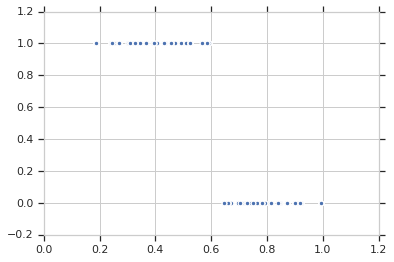

In [74]:
plt.scatter(df['STDEVAVG'],df['Volatility_Low'])

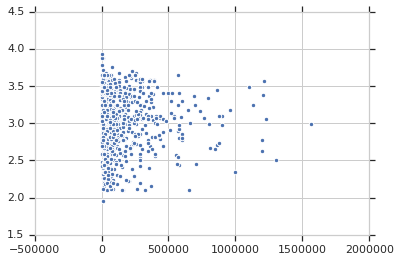

In [67]:
plt.scatter(df['Volume'],df['Sales_Price'])

In [70]:
plt.show()